In [2]:
import tensorflow as tf


# ImageDataGenerator():
#    입력으로 들어오는 이미지를 다양한 방향과 각도로 학습 시켜 텐서 이미지 데이터 배치를 생성한다
#    또, 많은 양의 데이터가 있다면 이를 다 불러올 수 없으므로 이미지의 사이즈를 조절해 파라미터를 이용해 이미지 스케일링을 해준다.
# ????????????????
#     - 파라미터
#         - rescale : 배율 조정
#         - zoom_range : 임의의 확대/축소 범위
#         - width_shift_range :  수평방향 내에서 임의로 원본 이미지 좌우로 이동
#         - height_shift_range :  수직방향 내에서 임의로 원본 이미지 상하로 이동
#         - validation_split : 주어진 데이터셋을 test와 training으로 나누는 비율

igd=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,
                                                    width_shift_range=0.1,
                                                    height_shift_range=0.1,
                                                    validation_split=0.2)

# flow_from_directory():
#      directory경로로부터 dataframe을 가져오고 augmented 또는 normalized된 data배치를 생선한다
#      주요 인자
#        - 첫번째 인자 : 이미지 경로를 지정
#        - target_size : 패치 이미지 크기 지정
#                       폴더에 있는 원본 이미지 크기가 다르더라도 target_size에 지정된 크기로 자동 조절
#       - batch_size : 배치 크기를 지정
#       - class_mode : 분류 방식에 대해 지정
#                    - categorical : 2D 원-핫 부호화된 라벨 반환
#                    - binary : 1D 이진 라벨 반환
#                    - sparse : 1D 정수 라벨 반환
#                    - None : 라벨이 반환되지 않음
#       - save_format : 저장 형태 지정
#                     - png (default)
#                     - jpg
#       - color_mode : 몇 개의 채널을 가질지 여부
#                    - grayscale 채널 1개
#                    - rbg 채널 3개 (default)
#                    - rgba 채널 4개
#       - subset : ImageDataGenerator에서 validation_split으로 선정한 training과 validation의 비율만큼 이미지를 가져옴

# 이미지 데이터들이 들어있는 directory자체를 불러와 training set 과  validation set을 나눠주기 위해 flow_from_directory()사용
traing_g=igd.flow_from_directory("./data/seg_train/seg_train", target_size=(128,128),
                               color_mode="rgb", class_mode="sparse",
                               batch_size=32,save_format="jpg", subset="training")

validation_g=igd.flow_from_directory("./data/seg_train/seg_train", target_size=(128,128),
                               color_mode="rgb", class_mode="sparse",
                               batch_size=32,save_format="jpg", subset="validation")


for image_batch,labels_batch in traing_g:
    print(image_batch.shape)
    print(labels_batch)
    break

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
(32, 128, 128, 3)
[3. 4. 4. 3. 3. 5. 3. 0. 3. 3. 2. 5. 3. 5. 4. 1. 2. 4. 0. 1. 3. 1. 0. 5.
 5. 2. 5. 2. 3. 3. 1. 2.]


- Conv2D : 특정한 패턴의 특징이 어디서 나타나는지를 확인하는 도구
    - 첫번째 인자 : filter 수 (filter 하나당 하나의 이미지가 만들어진다)\
        => 여기서는 첫번째 Conv2D에서 filter 수를 16개 지정해줘서 16개의 feature map이 만들어진다
    - 두번째 인자 : filter size
    - padding : 경계 처리 방법
        - vaild : 유효한 영역만 출력됨. 따라서, 출력이미지 사이즈는 입력이미지보다 작다
        - same : 출력 이미지 사이즈가 입력이미지 사이즈와 동일
    - input_shape : 샘플 수를 재외한 입력 형태 정의(모델에서 첫 레이어에만 적용 (행, 열, 채널 수) )
    - activation : 활성화 함수 설정
   
    <img src="./image/conv2d.png" height="200px" width="400px" >
    
- MaxPooling2D : feature map으로부터 값을 샘플링해서 정보를 압축한다
    *  MaxPooling2D 사용하는 이유
        - 이미지의 크기를 줄이면서 데이터의 손실을 막기 위해 합성곱 계층에서 스트라이드 값을 1로 지정하는 대신, 폴링 계층을 사용한다
        - 합성곱 계층의 과적합(overfittin)을 막기위해 사용한다
    
    <img src="./image/maxpooling2d.png" height="200px" width="400px" >

In [43]:
# 모델 생성

# 이미지를 높이 128, 너비 128, 채널 3으로 형태 정보를 준다
inputs=tf.keras.Input(shape=(128,128,3),name="img")

# Conv2D, MaxPooling2D으로 주요 특징을 추출(4차원)

# filter 수를 16개 지정해줘서 16개의 feature map이 만들어진다
c1=tf.keras.layers.Conv2D(16,(3,3),activation="relu",input_shape=(128,128,3))(inputs)
# feature map으로부터 값을 샘플링해서 정보를 압축한다(overfittin막기 위해 사용)
m1=tf.keras.layers.MaxPooling2D(2,2)(c1)

# BatchNormalization으로 평균 출력을 0에 가깝게 유지하고 출력 표준 편차를 1에 가깝게 유지하는 변환을 적용
b1=tf.keras.layers.BatchNormalization()(m1)

# filter 수를 32개 지정해주므로 32개의 feature map이 만들어진다
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu")(b1)
m2=tf.keras.layers.MaxPooling2D(2,2)(c2)

# Conv2D는 3차원 형태의 관측치를 입력으로 받는다 
# 그래서 Dense layer에 전달하기 위해 2차원 자료를 1차원 자료로 변환
f=tf.keras.layers.Flatten()(m2)

# overfitting을 막기위해 0.2비율로 몇개의 노드 Dropout

d=tf.keras.layers.Dense(64,activation="relu")(f)
dr=tf.keras.layers.Dropout(0.5)(d)
# 출력 뉴런수 6(label이 6개니까 6개로 설정)
# 활성화 함수로 softmax를 사용하여 해당 target의 확률 계산
outputs=tf.keras.layers.Dense(6,activation="softmax")(dr)

model=tf.keras.Model(inputs=inputs,outputs=outputs)

# 모델 학습과정 설정

# loss : 현재 가중치 세트를 평가하는데 사용한 손실함수
# 여기서는 훈련데이터의 label(target)이 정수라 SparseCategoricalCrossentropy사용

# optimizer : 최적의 가중치를 찾는데 사용되는 최적화 알고리즘으로 Adam사용

# Metric : 학습 평가 기준 (학습 과정 중 제대로 학습되고 있는지 확인)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 63, 63, 16)        64        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 28800)             0  

In [44]:
# 모델 학습

# fit() 인자
#   - 첫번째 인자 : training 시킬 데이터 입력
#   - epochs : 전체 훈련 데이터셋의 학습 반복 횟수 지정
#   - validation_data : 검증데이터셋을 제공할 제너레이터 지정
#   - validation_steps : epoch종료 때마다 검증 스텝수를 지정

history=model.fit(traing_g,epochs=10,validation_data=(validation_g))

Epoch 1/10
351/351 [==============================] - 44s 124ms/step - loss: 1.8214 - accuracy: 0.2874 - val_loss: 1.5987 - val_accuracy: 0.3527
Epoch 2/10
351/351 [==============================] - 43s 124ms/step - loss: 1.5149 - accuracy: 0.3595 - val_loss: 1.4997 - val_accuracy: 0.3877
Epoch 3/10
351/351 [==============================] - 43s 124ms/step - loss: 1.4513 - accuracy: 0.3677 - val_loss: 1.2869 - val_accuracy: 0.4797
Epoch 4/10
351/351 [==============================] - 44s 124ms/step - loss: 1.3970 - accuracy: 0.3885 - val_loss: 1.2515 - val_accuracy: 0.4918
Epoch 5/10
351/351 [==============================] - 43s 124ms/step - loss: 1.3242 - accuracy: 0.4232 - val_loss: 1.3004 - val_accuracy: 0.4501
Epoch 6/10
351/351 [==============================] - 43s 124ms/step - loss: 1.3117 - accuracy: 0.4235 - val_loss: 1.1169 - val_accuracy: 0.5257
Epoch 7/10
351/351 [==============================] - 44s 124ms/step - loss: 1.2617 - accuracy: 0.4437 - val_loss: 1.1273 - val_ac

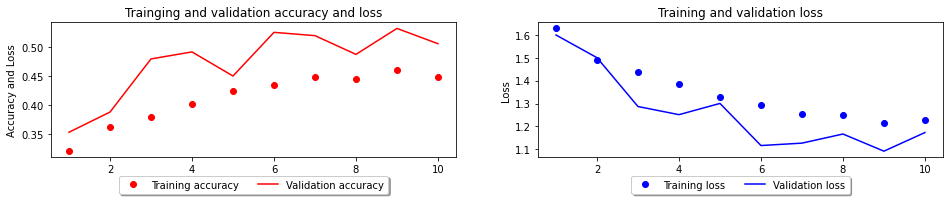

In [45]:
# 결과 시각화

# epoch별로 loss와 val_loss, acc와 val_acc의 경향보기
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(16, 1))

    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
               fancybox=True, shadow=True, ncol=5)

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
               fancybox=True, shadow=True, ncol=5)

    plt.show()

show_graph(history.history)

In [46]:
import numpy as np
# test data도 ImageDataGenerator 생성
test_igd = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255 )
test_g = test_igd.flow_from_directory("./data/seg_test/seg_test",target_size=(128,128),color_mode="rgb", class_mode="sparse",
                               batch_size=32,save_format="jpg")

# 모델 평가
evaluate=model.evaluate(test_g)
dict(zip(model.metrics_names, np.round(evaluate,4)))

Found 3000 images belonging to 6 classes.
94/94 [==============================] - 2s 24ms/step - loss: 1.5544 - accuracy: 0.4540


{'loss': 1.5544, 'accuracy': 0.454}

In [ ]:
# https://chunggaeguri.tistory.com/entry/ImageDataGenerator
# https://codetorial.net/tensorflow/convolutional_neural_network.html
# https://stackoverflow.com/questions/53941002/how-to-add-custom-filter-to-conv2d-layer-in-keras